## Data preparation folder2

In [4]:
#Retrieved the data from google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Loaded the necessary libraries
#keras is used for implementing the neural network
import numpy as np
import matplotlib.pyplot as plt
import collections
import os
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback

To Load image data 

In [6]:
images = np.load("/content/drive/My Drive/dataset/Fold 2/images/fold2/images.npy").astype(np.uint8) #converting the images to 8 bit interger
types = np.load("/content/drive/My Drive/dataset/Fold 2/images/fold2/types.npy")
masks = np.load("/content/drive/My Drive/dataset/Fold 2/masks/fold2/masks.npy").astype(np.uint8)
print("shape images:", images.shape)
print("types images:", types.shape)
print("masks images:", masks.shape)

shape images: (2523, 256, 256, 3)
types images: (2523,)
masks images: (2523, 256, 256, 6)


To plot the input images

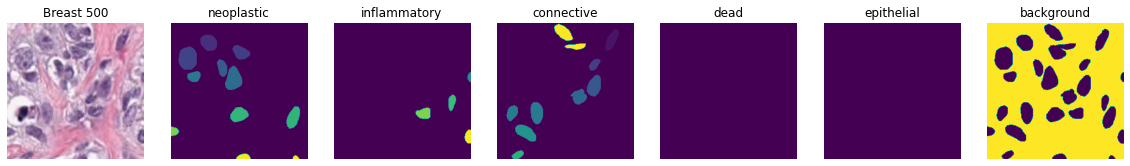

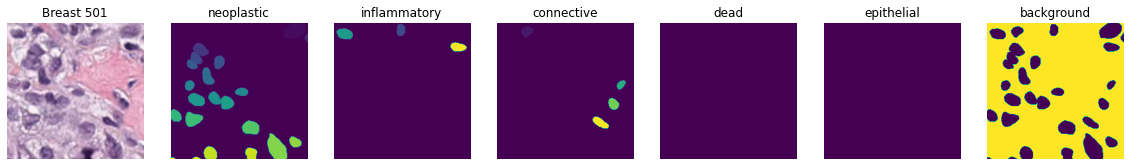

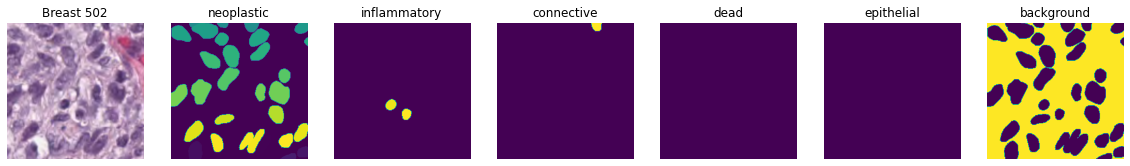

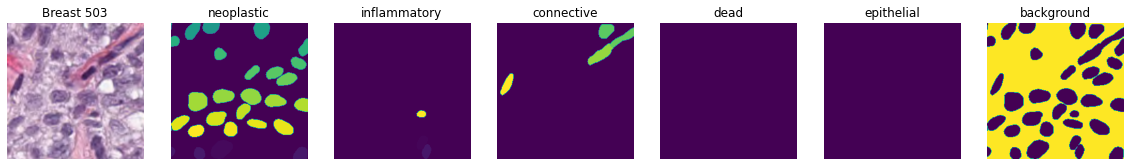

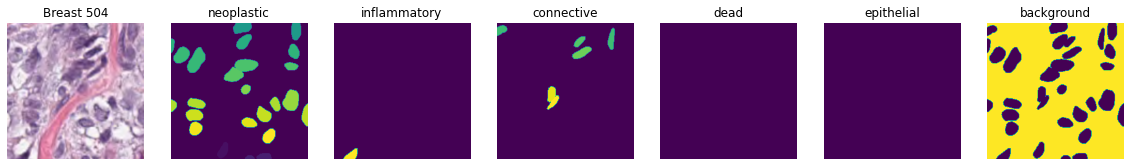

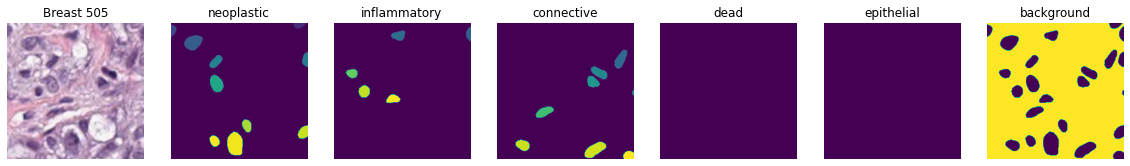

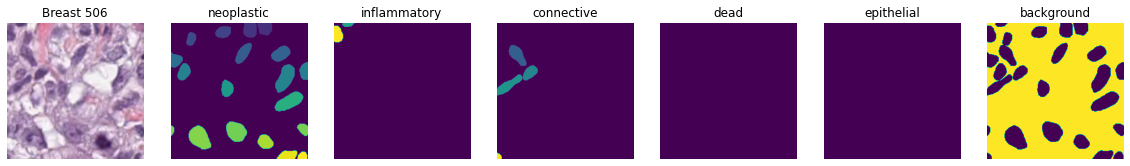

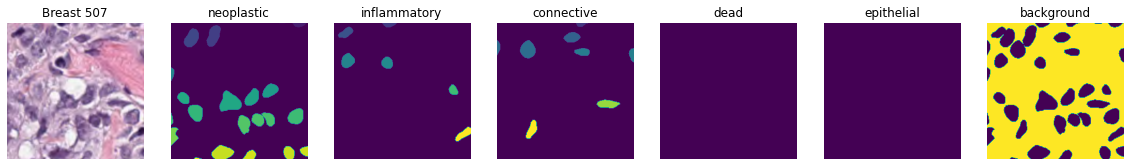

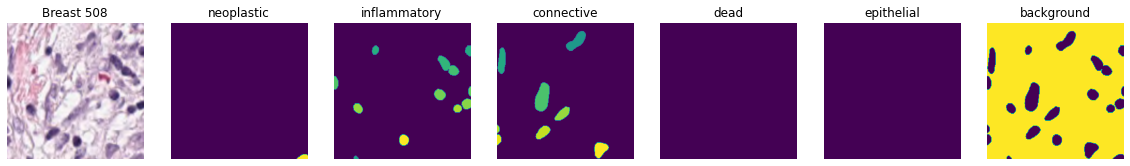

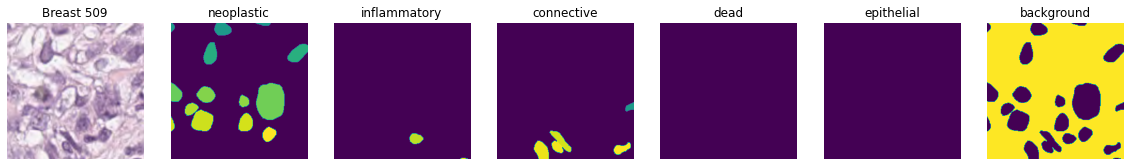

In [8]:
maskNames = ["neoplastic", "inflammatory", "connective", "dead", "epithelial", "background"]
def plot_images_mask(i, images, masks, figsize = (20,10)):
    global maskNames
    global types
    plt.figure(figsize=figsize)
    plt.subplot(171)
    plt.imshow(images[i])
    plt.title(types[i] + " " + str(i))
    plt.axis("off")
    
    for j in range(6):
        plt.subplot(172+j)
        plt.imshow(masks[i,:,:,j])
        plt.title(maskNames[j])
        plt.axis("off")
        
    plt.show()

for i in range(500, 510):
    plot_images_mask(i, images, masks)

In [10]:
#converting the inputs to 0 and 1 with 0 the background and 1 is the nuclei
x = images
y = masks[:,:,:,5]
y = np.where((y==0)|(y==1), y^1, y) # convert 0 to 1; 1 to 0
                                    

In [6]:
# Number of images
no_img = y.shape[0]
print("Number of images : %d \t " % (no_img))

# Compute width and height of images
img_ht = x.shape[1]
img_wd = y.shape[2]
print("Image size: %dx%d" % (img_wd, img_ht))

y = y.reshape(no_img, img_ht, img_ht, 1)
print(y.shape)

Number of images : 2523 	 
Image size: 256x256
(2523, 256, 256, 1)


In [7]:
counts = collections.Counter(types)
print(counts)

Counter({'Breast': 749, 'Colon': 468, 'HeadNeck': 169, 'Adrenal_gland': 148, 'Esophagus': 128, 'Bile-duct': 103, 'Pancreatic': 89, 'Skin': 87, 'Thyroid': 84, 'Testis': 79, 'Liver': 66, 'Bladder': 61, 'Kidney': 56, 'Lung': 53, 'Cervix': 52, 'Stomach': 48, 'Ovarian': 40, 'Prostate': 37, 'Uterus': 6})


Train-Test split

In [8]:
train_percentage=0.7
n_train = int(train_percentage*no_img)
x_train = x[0:n_train]
x_val   = x[n_train:]
y_train = y[0:n_train]
y_val   = y[n_train:]
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(1766, 256, 256, 3)
(757, 256, 256, 3)
(1766, 256, 256, 1)
(757, 256, 256, 1)


In [10]:
# Metric function to check the similarities between two samples 
#(i.e true and predicted images)
#the dice coefficient formula is 2 * overlapped area / sum of pixels in true and predicted images
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

UNET Architecture

In [11]:
from tensorflow.keras.optimizers import Adam
#Used UNet architecture for which c is convolution layer, d is dropout, 
#p is pooling layer, u for transpose
def u_net(img_wd=256,img_ht=256,channel=3):
    inputs = Input((img_ht, img_wd, channel))
    norm = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (norm)
    d1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    d2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    d3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    d4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    d5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    d6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    d7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    d8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    d9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    opt = Adam(learning_rate=0.0008)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=[dice_coef])
    model.summary()
    return model

Used only 5 epochs as part of training and the model will perform better with large epochs

In [13]:
# To set model Parameters
#Used basic parameters and only ran the model for 5 epochs
from tensorflow.keras import models
model = u_net()

history1 = model.fit(x_train, 
          y_train, 
          steps_per_epoch = n_train//32, 
          batch_size = 32,
          epochs =5, 
          shuffle=True, 
          initial_epoch=0, 
          validation_data = (x_val, y_val)
          


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [14]:
# History of accuracy and loss
tra_loss1 = history1.history['loss']
tra_dice_coef = history1.history['dice_coef']
val_loss1 = history1.history['val_loss']
val_dice_coef = history1.history['val_dice_coef']

# Total number of epochs training
epochs1 = range(1, len(tra_dice_coef)+1)
end_epoch1 = len(tra_dice_coef)

# Epoch when reached the validation loss minimum
opt_epoch1 = val_loss1.index(min(val_loss1)) + 1

# Loss and accuracy on the validation set
opt_val_loss1 = val_loss1[opt_epoch1-1]
opt_val_dice_coef = val_dice_coef[opt_epoch1-1]
print("Model 1\n")
print("Epoch [opt]: %d" % opt_epoch1)
print("Valid dice coef [opt]: %.4f" % opt_val_dice_coef)
# print("Test dice coef [opt]:  %.4f" % opt_test_dice_coef)
print("Valid loss [opt]: %.4f" % opt_val_loss1)
# print("Test loss [opt]:  %.4f" % opt_test_loss1)


Model 1

Epoch [opt]: 4
Valid dice coef [opt]: 0.5581
Valid loss [opt]: 0.2584


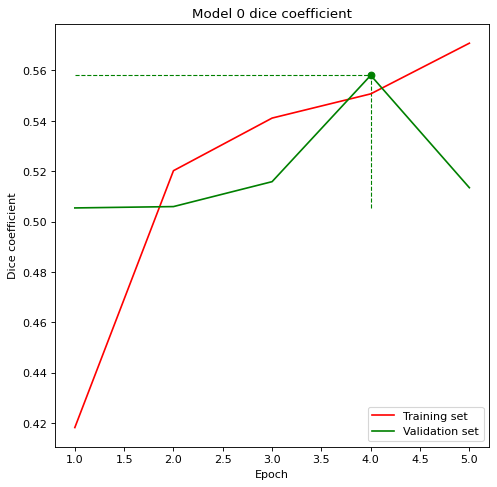

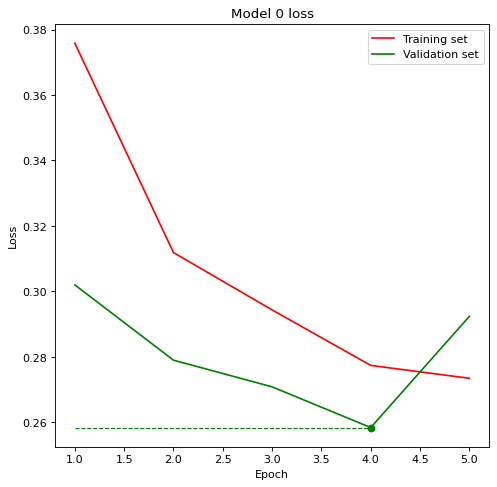

In [15]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 dice coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('Epoch')
plt.plot(epochs1, tra_dice_coef, 'r', label='Training set')
plt.plot(epochs1, val_dice_coef, 'g', label='Validation set')
plt.plot(opt_epoch1, val_dice_coef[opt_epoch1-1], 'go')
plt.vlines(opt_epoch1, min(val_dice_coef), opt_val_dice_coef, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_dice_coef, 1, opt_epoch1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs1, tra_loss1, 'r', label='Training set')
plt.plot(epochs1, val_loss1, 'g', label='Validation set')
plt.plot(opt_epoch1, val_loss1[opt_epoch1-1], 'go')
plt.vlines(opt_epoch1, min(val_loss1), opt_val_loss1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss1, 1, opt_epoch1, linestyle="dashed", color='g', linewidth=1)
plt.legend();